## Exploratory Data Analysis (EDA)

### Imports

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from itertools import combinations

### Load the Data

In [2]:
df = pd.read_csv('sales.csv').drop(columns='Row ID')

In [3]:
df.shape

(9800, 17)

In [7]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


### Explore the Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


We can see that Postal Code has some missing values, but grouping by Postal Code, City, or State would likely make the data too sparse to detect trends, so we won't bother with these features at all.

In [11]:
df.describe()

,Postal Code,Sales
count,9789.000000,9800.000000
mean,55273.322403,230.769059
std,32041.223413,626.651875
min,1040.000000,0.444000
25%,23223.000000,17.248000
50%,58103.000000,54.490000
75%,90008.000000,210.605000
max,99301.000000,22638.480000


#### Choosing a Time Interval

Our goal is to use time series analysis to predict Sales, so let's first determine an appropriate time interval.

In [13]:
# Convert 'Order Date' to datetime and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df.set_index('Order Date', inplace=True)

In [18]:
# Create time-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['Week'] = df.index.isocalendar().week
df['Quarter'] = df.index.quarter
df['Is Weekend'] = df['Weekday'].isin([5,6]).astype(int)

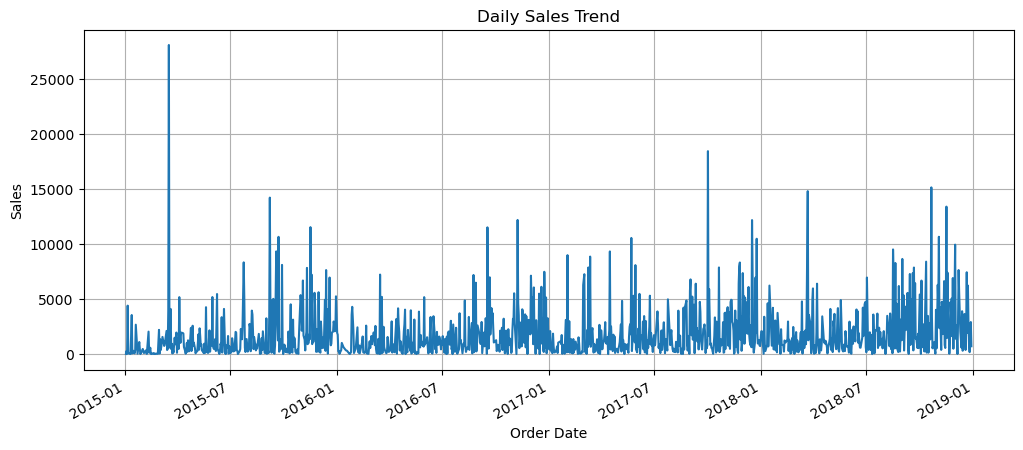

In [134]:
# Plot daily sales
plt.figure(figsize=(12, 5))
df.groupby(df.index)['Sales'].sum().plot(title='Daily Sales Trend')
plt.ylabel('Sales')
plt.grid()
plt.show()

The daily sales trend plot has a lot of variability that makes interpretability difficult.

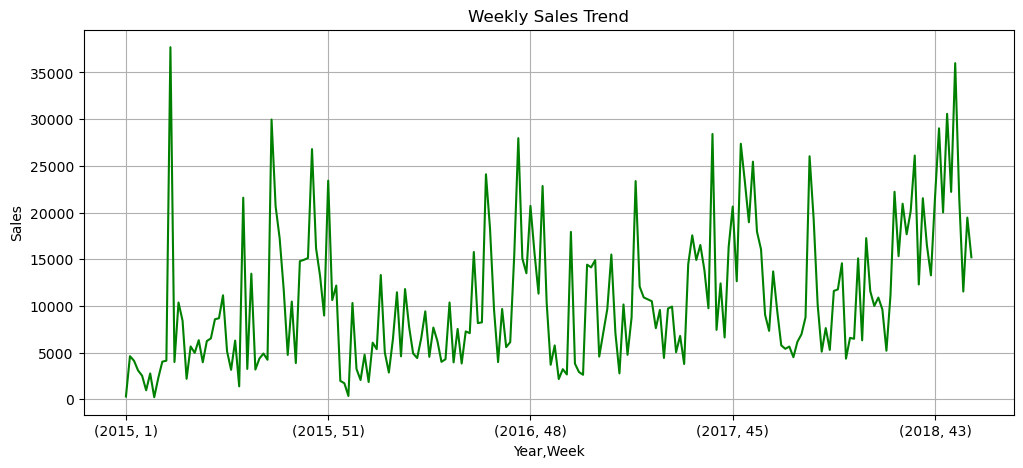

In [136]:
# Plot weekly sales
plt.figure(figsize=(12,5))
df.groupby(['Year', 'Week'])['Sales'].sum().plot(title='Weekly Sales Trend', color='green')
plt.ylabel('Sales')
plt.grid()
plt.show()

The weekly plot looks better, but patterns are still hard to detect.

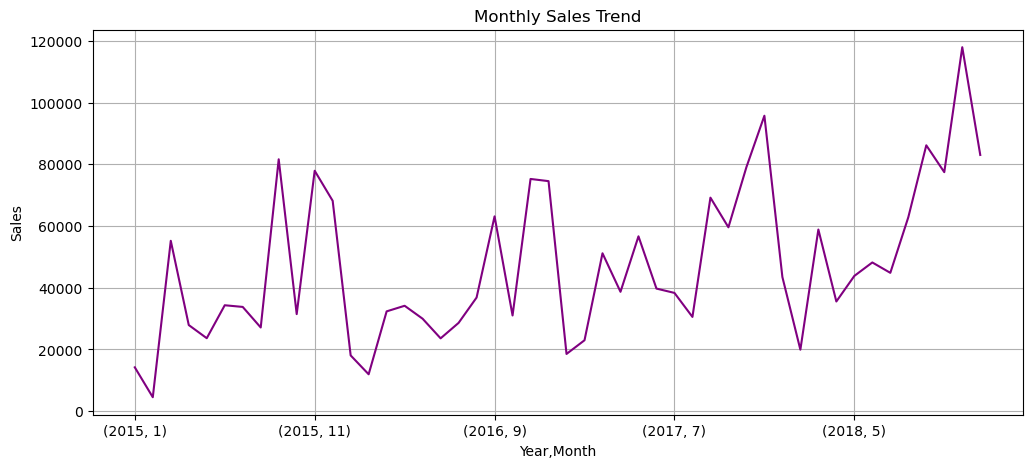

In [152]:
# Plot monthly sales
plt.figure(figsize=(12,5))
df.groupby(['Year', 'Month'])['Sales'].sum().plot(title='Monthly Sales Trend', color='purple')
plt.ylabel('Sales')
plt.grid()
plt.show()

In the monthly plot, sales appear to be increasing steadily over time. There are also obvious seasonality trends - sales hit annual minimums in January/February and have consistent spikes in September, November, and December.

The Coefficient of Variation (CV) is a good tool to help with deciding which interval to use. A CV < 0.5 indicates the data is stable and, therefore, daily trends are useful. If 0.5 <= CV < 1.0, weekly trends are useful. And finally, CV >= 1.0 indicates monthly trends being the best option.

In [162]:
cv = df['Sales'].std() / df['Sales'].mean()
print(f"Coefficient of Variation: {cv:.2f}")

Coefficient of Variation: 2.72


The plots and CV agree - monthly time grouping is the best option here.

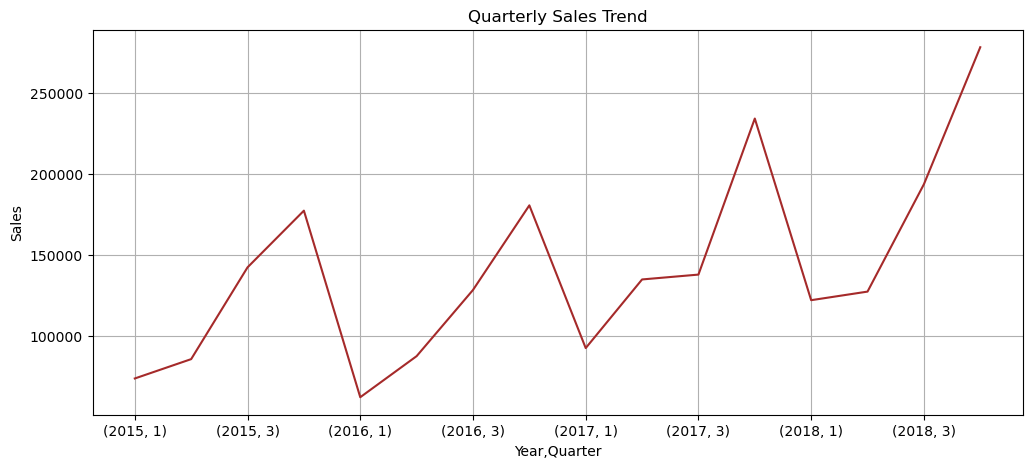

In [337]:
# Plot quarterly sales
plt.figure(figsize=(12,5))
df.groupby(['Year', 'Quarter'])['Sales'].sum().plot(title='Quarterly Sales Trend', color='brown')
plt.ylabel('Sales')
plt.grid()
plt.show()

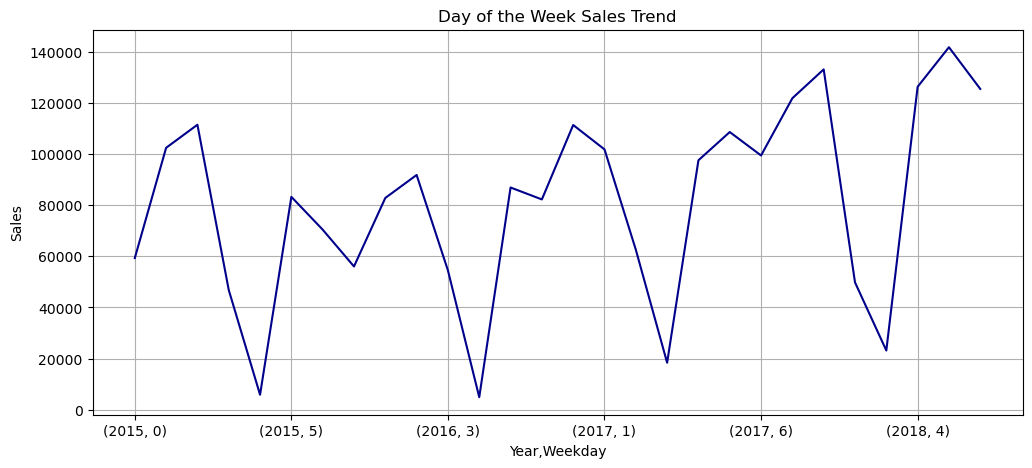

In [323]:
# Plot sales trend for day of week 
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Weekday'])['Sales'].sum().plot(title='Day of the Week Sales Trend', color='darkblue')
plt.ylabel('Sales')
plt.grid()
plt.show()

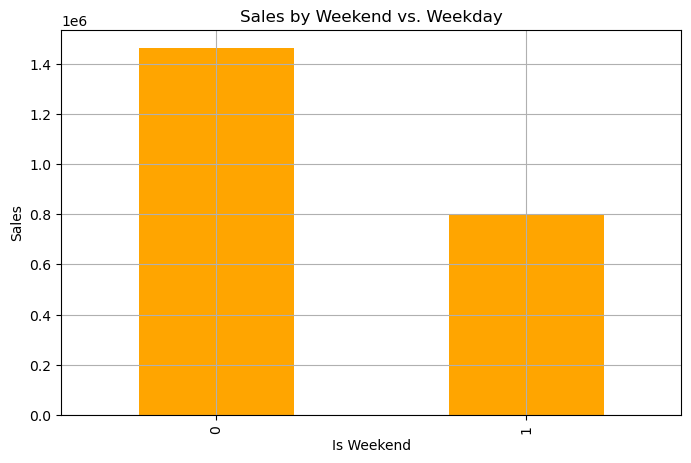

In [333]:
plt.figure(figsize=(8, 5))
df.groupby('Is Weekend')['Sales'].sum().plot(kind='bar', title='Sales by Weekend vs. Weekday', color='orange')
plt.ylabel('Sales')
plt.grid()
plt.show()

#### Target Feature Transformation

Let's take a quick look at the target feature, sales.

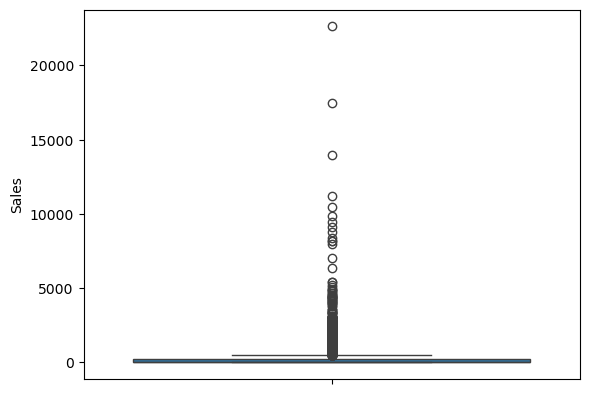

In [34]:
sns.boxplot(data=df, y='Sales')
plt.show()

There are so many outliers, we can't even properly see the IQR of the boxplot. Before removing outliers, let's try a log transformation.

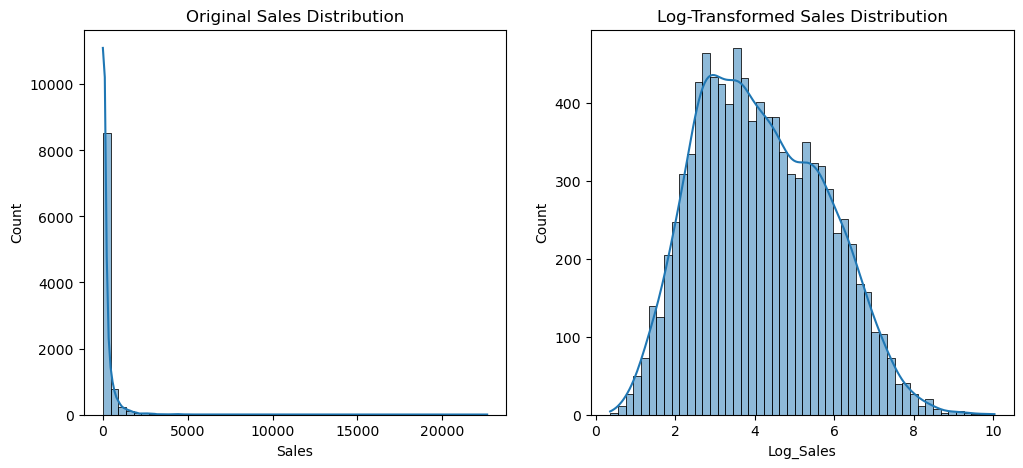

In [36]:
# Log Transform
df['Log_Sales'] = np.log(df['Sales'] + 1)

# Plot Before and After Log Transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Sales'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Original Sales Distribution")

sns.histplot(df['Log_Sales'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Sales Distribution")

plt.show()

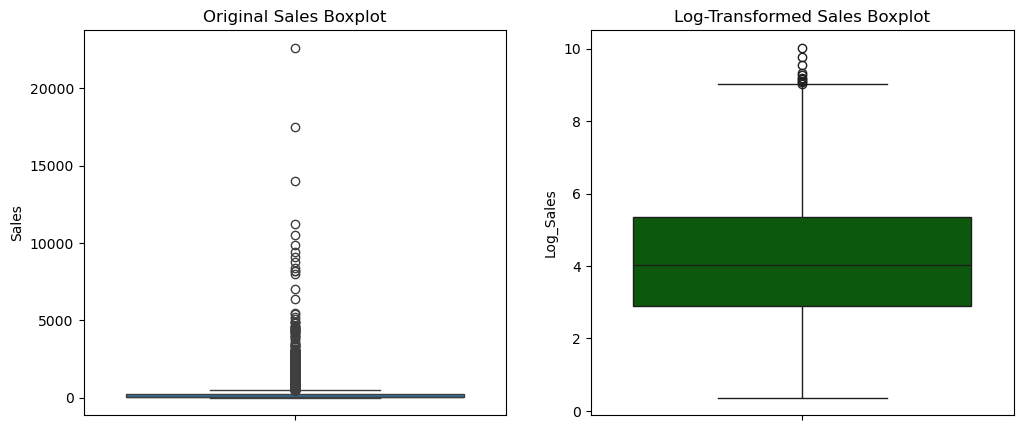

In [341]:
# Plot Before and After Log Transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(df['Sales'], ax=axes[0])
axes[0].set_title("Original Sales Boxplot")

sns.boxplot(df['Log_Sales'], ax=axes[1], color='darkgreen')
axes[1].set_title("Log-Transformed Sales Boxplot")

plt.show()

That looks better. Now let's take a look at some features of interest.

#### Categorical Features

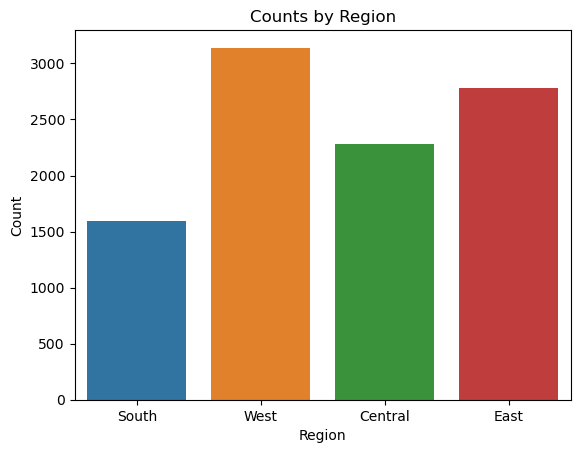

In [277]:
sns.countplot(data=df, x='Region', hue='Region')
plt.title('Counts by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

We see that the West region has the highest count, followed by East, and South with the least.

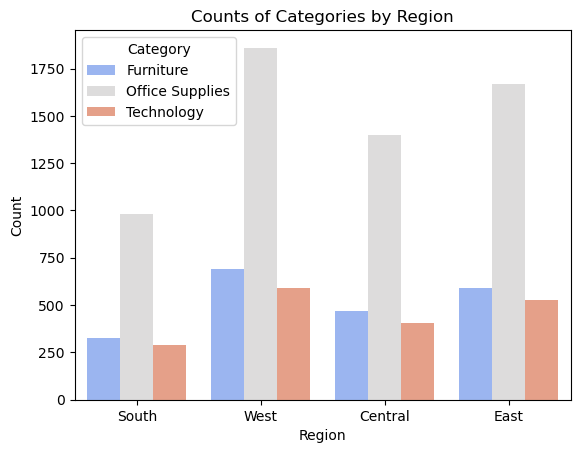

In [273]:
sns.countplot(data=df, x='Region', hue='Category', palette='coolwarm')
plt.title('Counts of Categories by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

The above plot shows us the breakdown of each region by category. We can see the South region has the smallest frequencies across every category. Also, regardless of region, office supplies make up the largest proportion of sales.

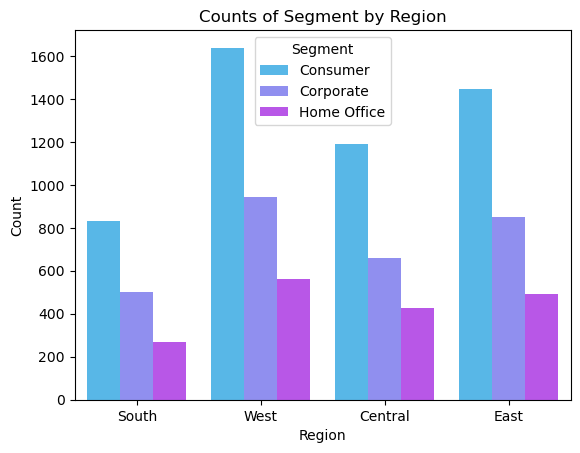

In [487]:
sns.countplot(data=df, x='Region', hue='Segment', palette='cool')
plt.title('Counts of Segment by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

Proportions seem to be very similar by segment for region as well. And, just as above, the South region has the smallest frequencies across all segments.  
Next, we can perform some Chi-Square Tests of Independence to see if the categorical features of interest are associated.

In [453]:
cols = ['Region', 'Segment', 'Category']
pairs = list(combinations(cols, 2))
results = {}

for col1, col2 in pairs:
    con_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(con_table)
    results[(col1, col2)] = {'Chi-Square': chi2, 'p-value': p, 'Degrees of Freedom': dof, 'Expected Frequencies': expected}

for pair, result in results.items():
    print(f"\nChi-Square Test between {pair[0]} and {pair[1]}:")
    print(f"Chi-Square Statistic: {result['Chi-Square']}")
    print(f"P-value: {result['p-value']}")
    print(f"Degrees of Freedom: {result['Degrees of Freedom']}")
    print(f"Expected Frequencies:\n{result['Expected Frequencies']}")


Chi-Square Test between Region and Segment:
Chi-Square Statistic: 4.20752335551208
P-value: 0.6486157291560657
Degrees of Freedom: 6
Expected Frequencies:
[[1185.20173469  686.1205102   405.6777551 ]
 [1449.62091837  839.19438776  496.18469388]
 [ 831.77530612  481.51979592  284.70489796]
 [1634.40204082  946.16530612  559.43265306]]

Chi-Square Test between Region and Category:
Chi-Square Statistic: 4.290472977284262
P-value: 0.6374317692943314
Degrees of Freedom: 6
Expected Frequencies:
[[ 482.81693878 1372.93806122  421.245     ]
 [ 590.53367347 1679.24132653  515.225     ]
 [ 338.84122449  963.52877551  295.63      ]
 [ 665.80816327 1893.29183673  580.9       ]]

Chi-Square Test between Segment and Category:
Chi-Square Statistic: 1.1483084048410648
P-value: 0.8865337450386218
Degrees of Freedom: 4
Expected Frequencies:
[[1081.62020408 3075.69479592  943.685     ]
 [ 626.15653061 1780.53846939  546.305     ]
 [ 370.22326531 1052.76673469  323.01      ]]


All expected frequencies are > 5, implying the validity of all chi-square test results. Furthermore, all p-values are > 0.05, indicating a failure to reject the null hypothesis, i.e., the categorical variables of interest are independent.  

#### Relationships of Categorical Features to Target Feature

Now can we can inspect our categorical features with respect to the target feature, Log_Sales.

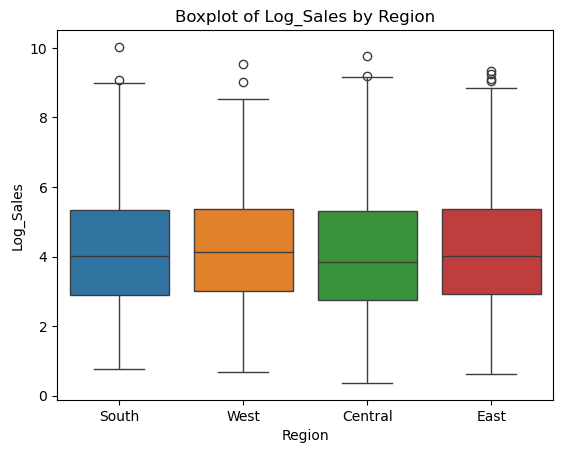

In [460]:
sns.boxplot(x='Region', y='Log_Sales', hue='Region', data=df)
plt.title('Boxplot of Log_Sales by Region')
plt.show()

The West region has a slightly narrower distribution than the others and all regions have a similar median value.

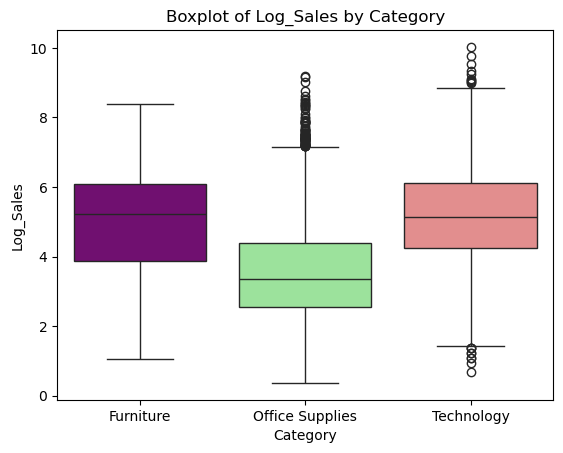

In [249]:
custom=['#800080', '#90EE90', '#F08080']
sns.boxplot(x='Category', y='Log_Sales', hue='Category', palette=custom, data=df)
plt.title('Boxplot of Log_Sales by Category')
plt.show()

Office supplies have a lower median value compared to furniture or technology, which is expected for obvious reasons.

In [50]:
for i in df['Category'].unique():
    print('Total sales for', i, 'amount to:', f'${df['Sales'][df['Category'] == i].sum():,.2f}')

Total sales for Furniture amount to: $728,658.58
Total sales for Office Supplies amount to: $705,422.33
Total sales for Technology amount to: $827,455.87


In [52]:
df.groupby('Category')['Sales'].mean()

Category
Furniture          350.653790
Office Supplies    119.381001
Technology         456.401474
Name: Sales, dtype: float64

We can see that office supplies have the lowest grand total and much lower average sale price.

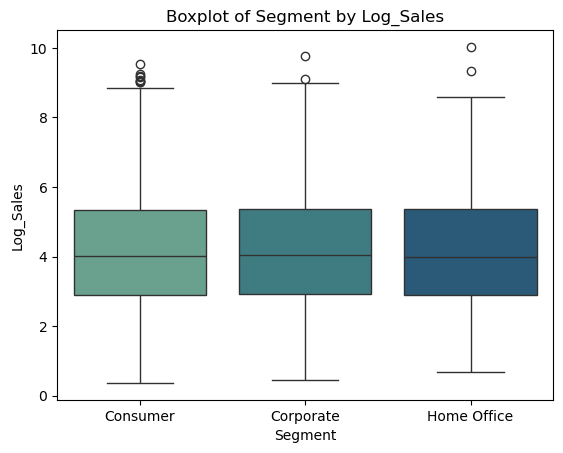

In [446]:
sns.boxplot(x='Segment', y='Log_Sales', hue='Segment', palette='crest', data=df)
plt.title("Boxplot of Segment by Log_Sales")
plt.show()

By segment, all boxplots look nearly identical. This feature may not be useful for analysis, but we will keep it for now.  

The analog to Chi-Square tests for categorical variables is a One-Way ANOVA for a numerical dependent variable with categorical independent variables.

In [462]:
for col in cols:
    groups = [df['Log_Sales'][df[col] == value] for value in df[col].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f'ANOVA for {col} - F-statistic: {f_stat}, P-value: {p_value}')

ANOVA for Region - F-statistic: 8.756334638031932, P-value: 8.514934088998994e-06
ANOVA for Segment - F-statistic: 0.24388492897407263, P-value: 0.7835825533151569
ANOVA for Category - F-statistic: 1367.7728422984112, P-value: 0.0


The ANOVA results agree with the boxplots above - none of the groups from Segment are significantly different from one another, but both Region and Category have at least one group mean that is significantly different from its remaining group means.

#### Time Trends

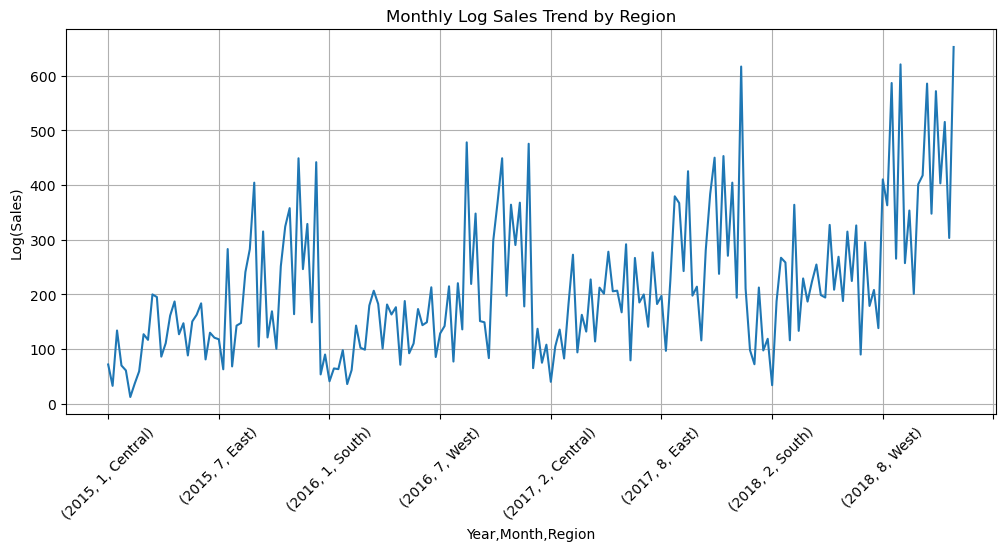

In [223]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Month', 'Region'])['Log_Sales'].sum().plot(title='Monthly Log Sales Trend by Region')
plt.ylabel('Log(Sales)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

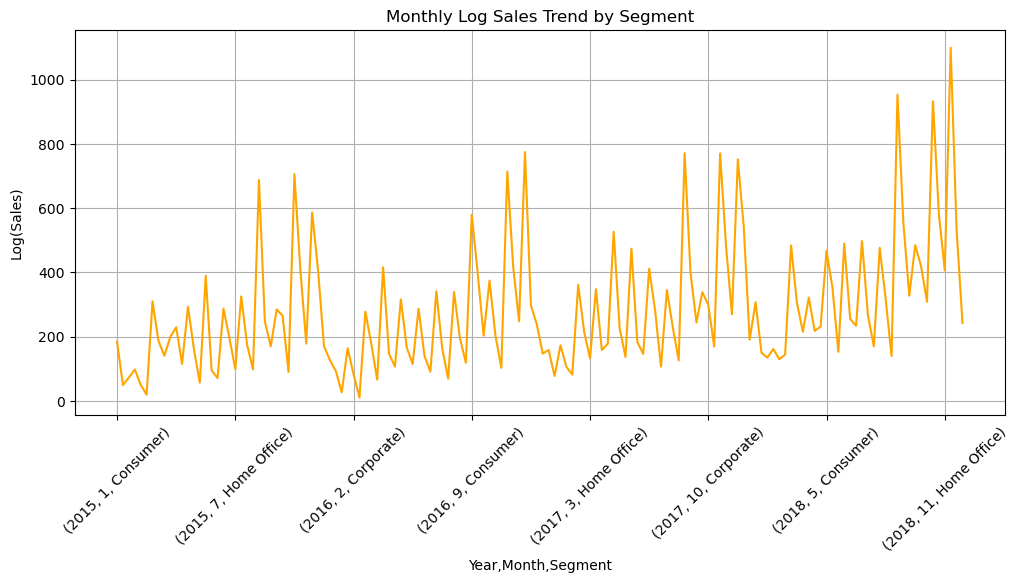

In [349]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Month', 'Segment'])['Log_Sales'].sum().plot(title='Monthly Log Sales Trend by Segment', color='orange')
plt.ylabel('Log(Sales)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

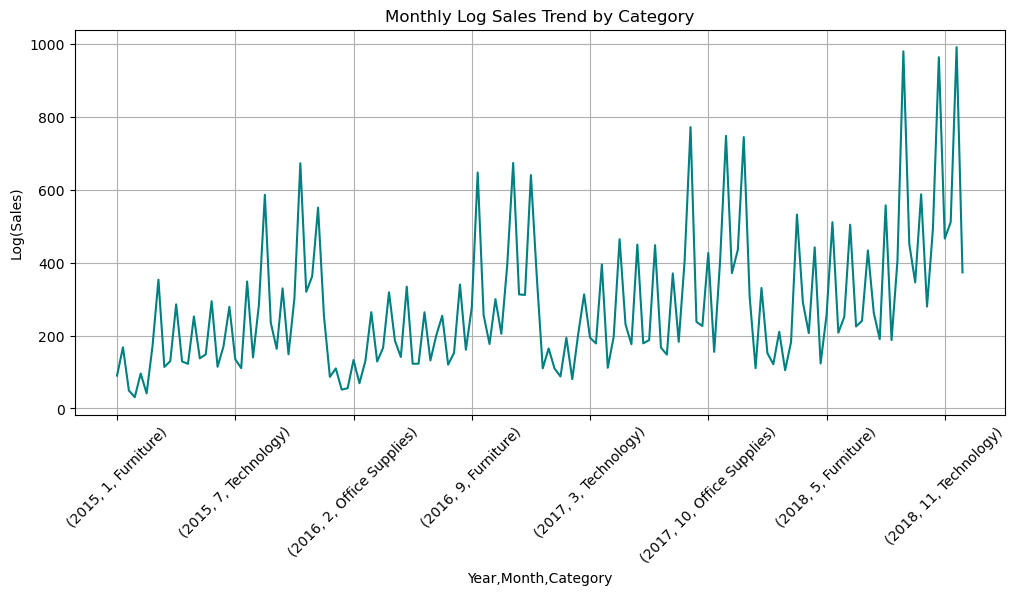

In [351]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Month', 'Category'])['Log_Sales'].sum().plot(title='Monthly Log Sales Trend by Category', color='teal')
plt.ylabel('Log(Sales)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

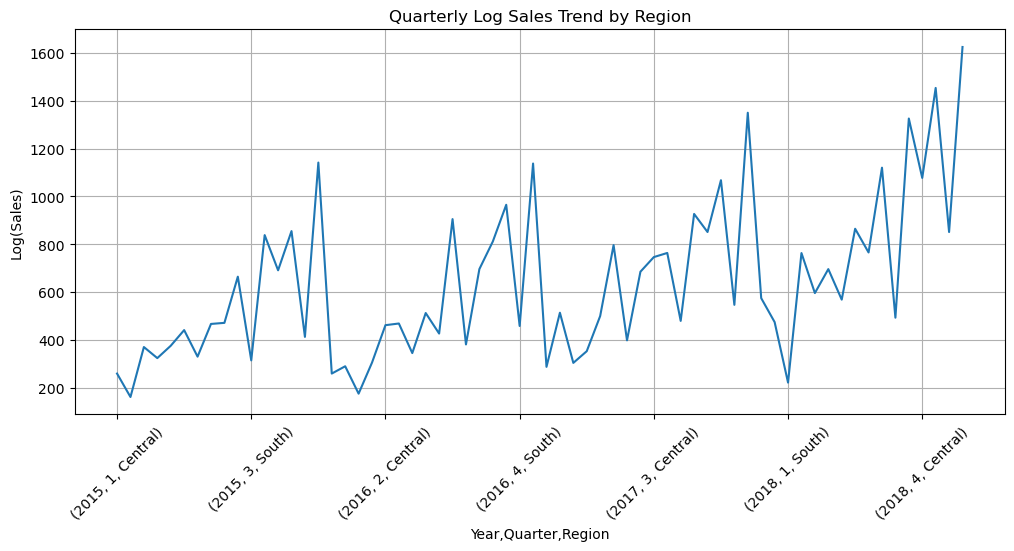

In [359]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Quarter', 'Region'])['Log_Sales'].sum().plot(title='Quarterly Log Sales Trend by Region')
plt.ylabel('Log(Sales)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

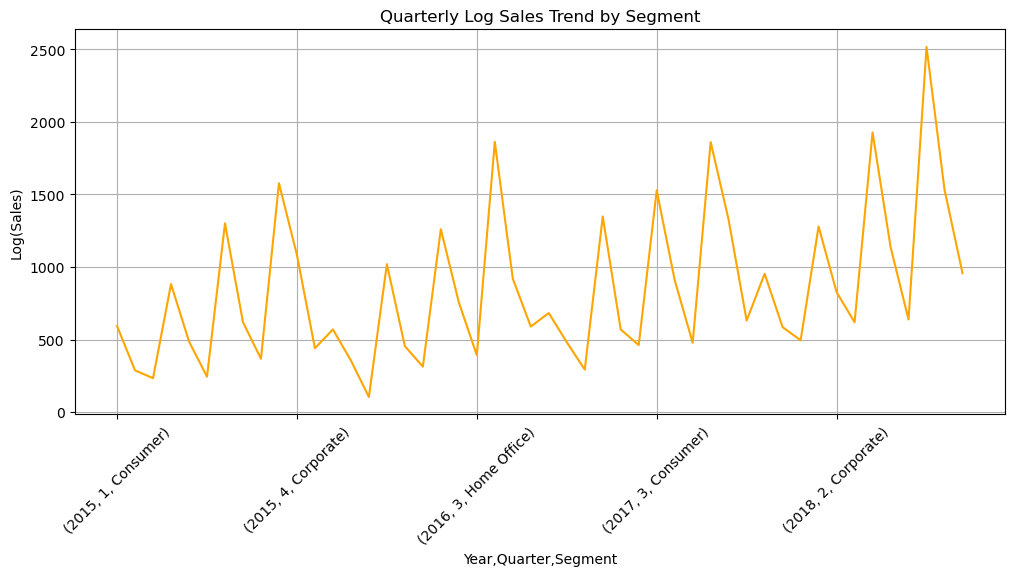

In [361]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Quarter', 'Segment'])['Log_Sales'].sum().plot(title='Quarterly Log Sales Trend by Segment', color='orange')
plt.ylabel('Log(Sales)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

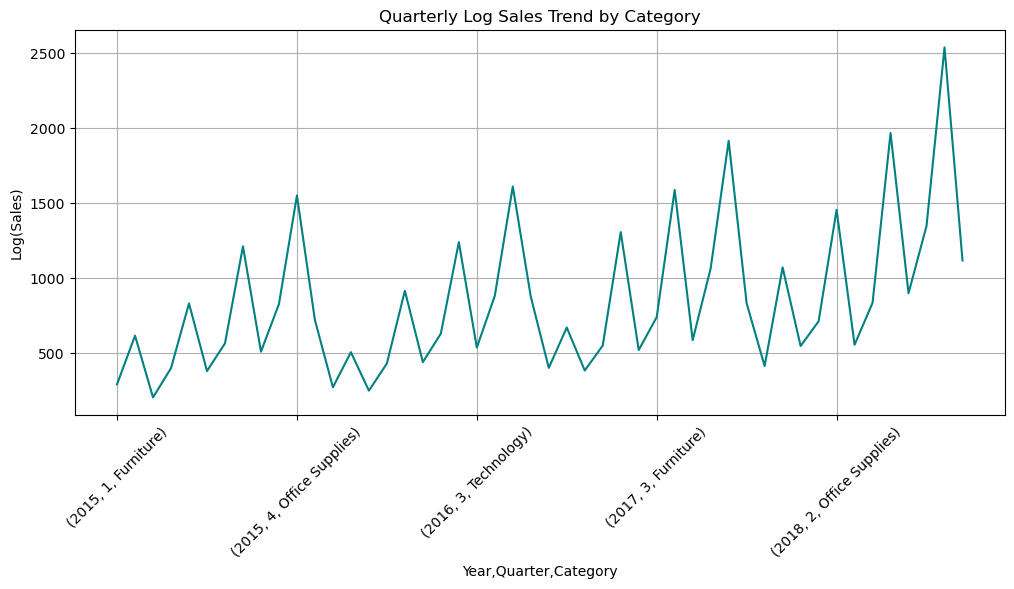

In [363]:
plt.figure(figsize=(12, 5))
df.groupby(['Year', 'Quarter', 'Category'])['Log_Sales'].sum().plot(title='Quarterly Log Sales Trend by Category', color='teal')
plt.ylabel('Log(Sales)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

Monthly and quarterly sales trends by Region, Segment, and Category all appear to have repeating patterns.